In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import sem, t

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

First, let us start by reading the data

In [91]:
data = pd.read_csv(r"C:\Users\user\Desktop\OKUL\BAHAR_23-24\MAT388-Data_Analysis\Final Project\data.csv", delimiter='\t')
data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
0,4,28,3890,4,25,2122,2,16,1944,4,...,1,1,1,12,1,10,2,1,2,NaN
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,2,7,0,70,2,1,4,NaN
2,3,7,5784,1,33,4373,4,41,3242,1,...,2,1,1,4,3,60,1,1,3,NaN
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,2,4,5,70,2,1,5,biology
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,2,3,10,1,10,2,1,4,Psychology


## Pre-processing

For Q questions, A:answer , E:time taken, I : position of the question. As we are not interested in time or order,we will just consider the answers.

In [92]:
columns_to_remove = [col for col in data.columns if (col.endswith('I') or col.endswith('E'))]

new_df = data.drop(columns=columns_to_remove)
new_df2=new_df.copy()
new_df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
0,4,4,2,4,4,4,4,4,2,1,...,1,1,1,12,1,10,2,1,2,NaN
1,4,1,2,3,4,4,3,4,3,2,...,2,1,2,7,0,70,2,1,4,NaN
2,3,1,4,1,4,3,1,3,2,4,...,2,1,1,4,3,60,1,1,3,NaN
3,2,3,2,1,3,3,4,2,3,3,...,2,1,2,4,5,70,2,1,5,biology
4,2,2,3,4,4,2,4,4,4,3,...,2,2,3,10,1,10,2,1,4,Psychology


Columns started with 'VCL' were presented as a check-list and subjects were instructed in the grid below, check all the words whose definitions you are sure you know. \
VCL6, VCL9, and VCL12 are not real words and can be used as a validity check.

In [93]:
valid_rows = ~new_df[['VCL6','VCL9','VCL12']].eq(1).any(axis=1)
new_df= new_df[valid_rows]

In [94]:
print('previous size:',data.shape, 'current size:',new_df.shape)

previous size: (39775, 172) current size: (34583, 88)


As, we can see almost 5k answer are invalid. \
Now, we do not need 'VCL' coded columns:

In [95]:
columns_to_drop = [col for col in new_df.columns if col.startswith('VCL')]

# Drop the columns starting with 'VCL'
new_df.drop(columns=columns_to_drop, inplace=True)

In [96]:
missing = new_df.isna().sum()
missing[missing != 0]

country       2
major      9571
dtype: int64

As there are too many missing values in 'major' column, we will delete it. Also drop other 2 rows which has missing values(country)

In [97]:
new_df.drop(columns='major', inplace=True)

In [98]:
new_df.dropna(inplace=True)

Let us look at our target variable: \
y(target) : \
'urban'("What type of area did you live when you were a child?") : 1=Rural (country side), 2=Suburban, 3=Urban (town, city) \
We can look at the distribution of target variable

In [99]:
new_df['urban'].value_counts()

3    15668
2    11317
1     7252
0      344
Name: urban, dtype: int64

0 is invalid input. Thus, we also delete these rows:

In [100]:
new_df = new_df[new_df['urban'] != 0]
new_df = new_df.reset_index(drop=True)     

In [101]:
new_df.shape

(34237, 71)

In [102]:
new_df.isna().sum().sum()

0

Now, let us look  at general information about dataset and see data types

In [103]:
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34237 entries, 0 to 34236
Data columns (total 71 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Q1A                    34237 non-null  int64 
 1   Q2A                    34237 non-null  int64 
 2   Q3A                    34237 non-null  int64 
 3   Q4A                    34237 non-null  int64 
 4   Q5A                    34237 non-null  int64 
 5   Q6A                    34237 non-null  int64 
 6   Q7A                    34237 non-null  int64 
 7   Q8A                    34237 non-null  int64 
 8   Q9A                    34237 non-null  int64 
 9   Q10A                   34237 non-null  int64 
 10  Q11A                   34237 non-null  int64 
 11  Q12A                   34237 non-null  int64 
 12  Q13A                   34237 non-null  int64 
 13  Q14A                   34237 non-null  int64 
 14  Q15A                   34237 non-null  int64 
 15  Q16A               

We can reduce the number of columns by using some feature selection methods.

### Feature Selection

There are mainly 3 automatic feature selection methods: 
- univariate statistics
- model-based selection
- iterative selection. \
Here, we're gonna use univariate statistics.

In univariate statistics, we compute whether there is a statistically significant relationship
between each feature and the target. Then the features that are related with the
highest confidence are selected. In the case of classification, this is also known as
analysis of variance (ANOVA). A key property of these tests is that they are univariate,
meaning that they only consider each feature individually. Consequently, a feature
will be discarded if it is only informative when combined with another feature.
Univariate tests are often very fast to compute, and don’t require building a model.
On the other hand, they are completely independent of the model that you might
want to apply after the feature selection.

Here, we will use univariate feauture selection method, thus we removed only object type and target columns and apply the method, then add the column back.(univariate feature selection, Introduction to Machine Learning with Python, Andreas C. Müller & Sarah Guido)

In [104]:
new_df.shape

(34237, 71)

In [105]:
x_new = new_df.drop(columns=['country','urban'])
target=new_df['urban']

Except 'country', we have 69 columns, i want to reduce the # of columns to 50 in total.

In [106]:
selector = SelectKBest(f_classif, k=49) # f_class for classification, f_regression for regression
x_data = selector.fit_transform(x_new, target)

selected_indices = selector.get_support(indices=True)

# Get the column names of the selected features
selected_column_names = x_new.columns[selected_indices]

# Create a new DataFrame with selected features
selected_features_df = pd.DataFrame(x_data, columns=selected_column_names)

In [108]:
selected_features_df['country'] = new_df['country']
selected_features_df['urban'] = new_df['urban']

In [109]:
selected_features_df.isna().sum().sum()

0

In [110]:
print(selected_features_df.columns)

Index(['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q11A', 'Q12A',
       'Q13A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A', 'Q21A', 'Q23A',
       'Q25A', 'Q28A', 'Q29A', 'Q30A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A',
       'Q38A', 'Q40A', 'Q41A', 'Q42A', 'source', 'TIPI1', 'TIPI4', 'TIPI9',
       'TIPI10', 'education', 'gender', 'engnat', 'age', 'screensize',
       'uniquenetworklocation', 'religion', 'orientation', 'race', 'voted',
       'married', 'familysize', 'country', 'urban'],
      dtype='object')


Source, unitnetworklocation and screensize are irrelevant columns, they might be useful for advertisement etc. but we are not gonna use these 2 columns.

In [111]:
selected_features_df.drop(columns=['source','uniquenetworklocation','screensize'],inplace=True)

Let us have a look at definitions of columns, and identify which are numerical/categorical: \
Q?A: 4 point rating scale of answers(categorical(ordinal)) \
surveyelapse: the time spent answering the rest of the demographic and survey questions(numerical) \
TIPI?: 7 point rating scale(categorical(ordinal)) \
education: 4 point degree scale(categorical(ordinal)) \
gender: 3 point (categoical) \
engnat: 2 point (categorical) \
age: (numerical) \
religion: 12 point (categorical) \
orientation: 5 point (categorical) \
race: 7 point (categorical) \
voted: 2 point (categorical) \
married: 3 point(categorical) \
familysize: (numerical) \
country: ISO code (categorical) 

To make the process easier, we can group columns by their type(num/cat):

In [112]:
num_cols=['surveyelapse','age','familysize']
cat_cols = [col for col in selected_features_df.columns if col not in num_cols]

Now, let us check the distribution of the target values:

In [113]:
class_distribution = target.value_counts(normalize=True)
cluster_probabilities = class_distribution / class_distribution.sum()
cluster_probabilities

3    0.457634
2    0.330549
1    0.211818
Name: urban, dtype: float64

It is relatively balanced.

In [114]:
selected_features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Q1A,34237.0,2.621375,1.027187,1.0,2.0,3.0,4.0,4.0
Q2A,34237.0,2.166224,1.107983,1.0,1.0,2.0,3.0,4.0
Q3A,34237.0,2.211613,1.030551,1.0,1.0,2.0,3.0,4.0
Q4A,34237.0,1.930572,1.031601,1.0,1.0,2.0,3.0,4.0
Q6A,34237.0,2.534977,1.044955,1.0,2.0,2.0,3.0,4.0
Q7A,34237.0,1.903467,1.020928,1.0,1.0,2.0,3.0,4.0
Q8A,34237.0,2.457634,1.046916,1.0,2.0,2.0,3.0,4.0
Q9A,34237.0,2.664486,1.064611,1.0,2.0,3.0,4.0,4.0
Q11A,34237.0,2.807693,1.046833,1.0,2.0,3.0,4.0,4.0
Q12A,34237.0,2.407571,1.059631,1.0,2.0,2.0,3.0,4.0


No parameters should have the value 0, so we will delete the rows with 0 values:

In [115]:
selected_features_df = selected_features_df[(selected_features_df != 0).all(axis=1)]

When we look at the max of age and familysize, there might be some outliers. \
To check potential anomalies, we will define a function which visualize the distribution of both categorical and numerical columns

In [116]:
def visualize_column_distribution(df, column_name, column_type):
    if column_type == 'categorical':
        # Kategorik sütun için bar plot çizimi
        fig = px.bar(df[column_name].value_counts(), title=f'{column_name} Distribution')
        fig.update_xaxes(title=column_name)
        fig.update_yaxes(title='Count')
        fig.show()
    elif column_type == 'numerical':
        # Sayısal sütun için violin plot ve histogram çizimi
        fig = make_subplots(rows=1, cols=2, subplot_titles=(f'{column_name} Distribution (Violin Plot)', f'{column_name} Distribution (Histogram)'))
        
        violin_fig = px.violin(df, y=column_name, box=True)
        fig.add_trace(go.Violin(y=violin_fig.data[0]['y'], box_visible=True), row=1, col=1)
        
        hist_fig = px.histogram(df, x=column_name)
        fig.add_trace(go.Histogram(x=hist_fig.data[0]['x']), row=1, col=2)
        
        fig.update_xaxes(title_text=column_name, row=1, col=1)
        fig.update_yaxes(title_text='Value', row=1, col=1)
        
        fig.update_xaxes(title_text=column_name, row=1, col=2)
        fig.update_yaxes(title_text='Frequency', row=1, col=2)
        
        fig.show()

In [117]:
visualize_column_distribution(selected_features_df,'age','numerical')

In [118]:
visualize_column_distribution(selected_features_df,'familysize','numerical')

As we can see there are outliers in familysize and age. Thus, we can drop some parts:

In [119]:
df_filtered = selected_features_df.query('familysize < 22 & age < 118')

Now, let us see the distribution of cateogorical variables:

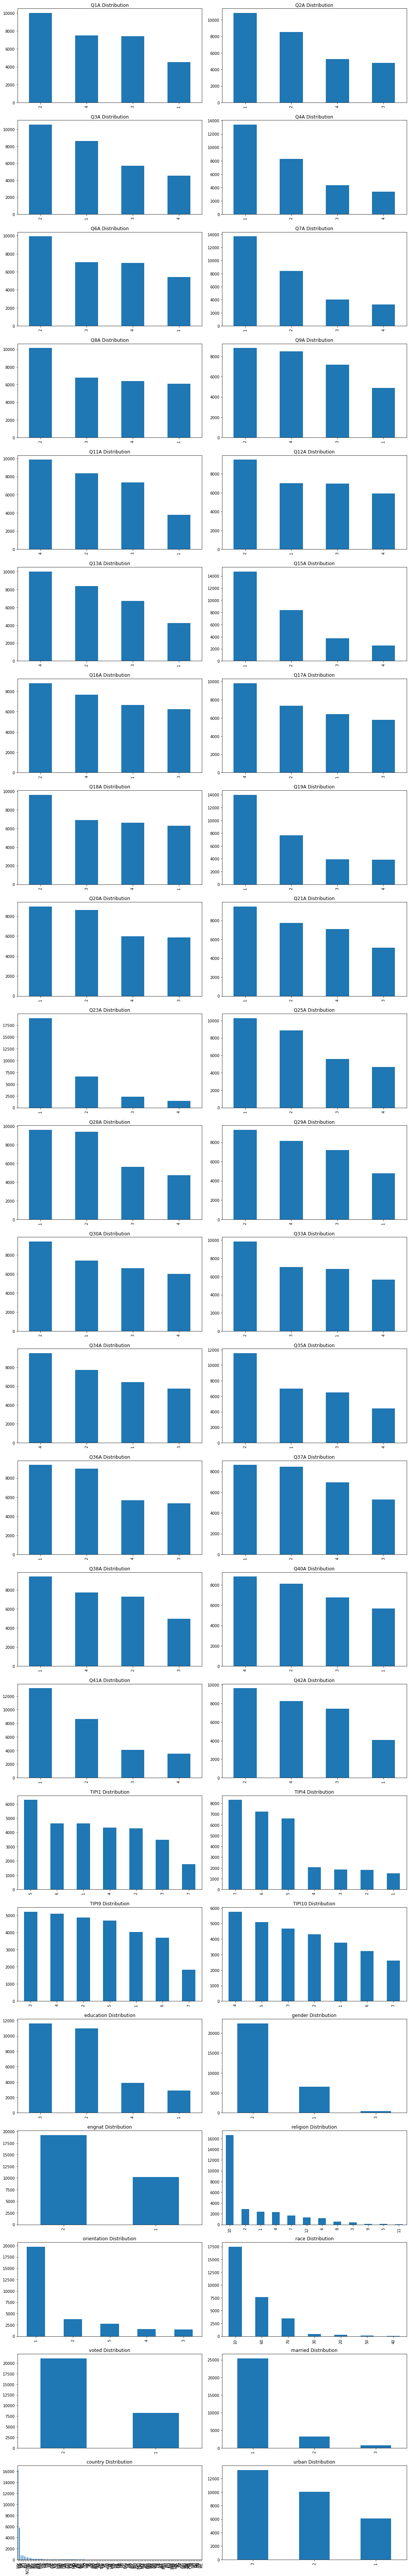

In [120]:
sutun_sayisi = len(cat_cols)
fig, axs = plt.subplots((sutun_sayisi + 1) // 2, 2, figsize=(15, (sutun_sayisi + 1) * 2))


for i, sutun in enumerate(cat_cols):
    ax = axs[i // 2, i % 2]
    df_filtered[sutun].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(sutun + ' Distribution')

if sutun_sayisi % 2 != 0:
    fig.delaxes(axs[sutun_sayisi // 2, 1])

plt.tight_layout()
plt.show()

Let us look at the country values:

In [121]:
df_filtered['country'].value_counts()

MY    16190
US     5751
GB      844
CA      727
ID      716
      ...  
IM        1
LU        1
TN        1
UZ        1
RE        1
Name: country, Length: 139, dtype: int64

In [122]:
visualize_column_distribution(df_filtered,'country','categorical')

Country column has an imbalanced data, we will also drop it.

In [123]:
df2=df_filtered.drop(columns=['country'])

For the columns which are not ordinal, we will do one hot encoding to avoid affecting the model incorrectly. \
(gender,engnat,religion,orientation,race,voted,married)

In [124]:
df_encoded = pd.get_dummies(df2, columns=['gender', 'engnat', 'religion', 'orientation', 'race', 'voted', 'married'])
df_encoded

,Q1A,Q2A,Q3A,Q4A,Q6A,Q7A,Q8A,Q9A,Q11A,Q12A,...,race_30,race_40,race_50,race_60,race_70,voted_1,voted_2,married_1,married_2,married_3
0,4,4,2,4,4,4,4,2,4,4,...,0,0,0,0,0,0,1,1,0,0
2,3,1,4,1,3,1,3,2,2,1,...,0,0,0,1,0,1,0,1,0,0
3,2,3,2,1,3,4,2,3,2,1,...,0,0,0,0,1,0,1,1,0,0
4,2,2,3,4,2,4,4,4,2,4,...,0,0,0,0,0,0,1,1,0,0
5,1,1,2,1,1,1,3,3,1,2,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34232,3,4,2,2,4,4,2,1,3,3,...,0,0,0,0,1,0,1,1,0,0
34233,2,1,3,2,2,1,3,1,2,2,...,0,0,0,1,0,0,1,1,0,0
34234,2,1,2,1,1,1,1,2,1,1,...,1,0,0,0,0,1,0,0,1,0
34235,3,1,2,2,3,3,4,3,3,3,...,0,0,0,1,0,1,0,1,0,0


## Model Construction

In [125]:
y=df_encoded['urban']
X=df_encoded.drop(columns=['urban'])

In [126]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [127]:
def classifier_model(x_train, x_test, y_train, y_test, classifier, model): #ensemble model
    model = classifier(model)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return classification_report(y_test, y_pred, output_dict=True)

def average_classification_reports(reports): #run multiple times
    avg_report = {}
    for key in reports[0].keys():
        if key == 'accuracy':
            avg_report[key] = np.mean([report[key] for report in reports])
        else:
            avg_report[key] = {}
            for sub_key in reports[0][key].keys():
                avg_report[key][sub_key] = np.mean([report[key][sub_key] for report in reports])
    return avg_report

def create_classification_report_dataframe(report): #for better visualization
    report_data = []
    for label, metrics in report.items():
        if label == 'accuracy':
            report_data.append([label, '', '', '', metrics])
        else:
            report_data.append([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])
    dataframe = pd.DataFrame(report_data, columns=['Label', 'Precision', 'Recall', 'F1-Score', 'Support'])
    return dataframe

def train_and_evaluate_models(X,y, num_runs=5):
    reg_models = {
        'Logistic Regression': LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=4000),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, criterion='entropy')
    }

    ens_models = {
        'Random Forest': RandomForestClassifier(n_estimators=10),
        'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
        'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=10),
        'LightGBM': LGBMClassifier(num_leaves=10, n_estimators=50)
    }

    all_models = {**reg_models, **ens_models}

    for model_name, model in all_models.items():
        print(f"Training and evaluating {model_name}...")
        reports = []
        start_time = time.time()
        for _ in range(num_runs):
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
            if model_name in reg_models:
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                reports.append(classification_report(y_test, y_pred, output_dict=True))
            else:
                report = classifier_model(x_train, x_test, y_train, y_test, OneVsRestClassifier, model)
                reports.append(report)
        avg_report = average_classification_reports(reports)
        report_df = create_classification_report_dataframe(avg_report)
        print(report_df)
        end_time = time.time()
        print(f"Time taken: {end_time - start_time:.2f} seconds\n")

In [128]:
train_and_evaluate_models(X,y)

Training and evaluating Logistic Regression...
          Label Precision    Recall  F1-Score      Support
0             1  0.402401  0.062655  0.108353  1213.000000
1             2  0.439956  0.289463  0.349157  2012.000000
2             3  0.488229  0.803469   0.60738  2652.000000
3      accuracy                                   0.474596
4     macro avg  0.443528  0.385196  0.354963  5877.000000
5  weighted avg  0.453988  0.474596  0.415979  5877.000000
Time taken: 22.72 seconds

Training and evaluating Decision Tree...
          Label Precision    Recall  F1-Score      Support
0             1   0.32169    0.1169  0.170987  1213.000000
1             2  0.430358  0.376441  0.400969  2012.000000
2             3  0.504054  0.698265  0.585318  2652.000000
3      accuracy                                   0.468096
4     macro avg    0.4187  0.397202  0.385758  5877.000000
5  weighted avg  0.441184  0.468096  0.436689  5877.000000
Time taken: 2.15 seconds

Training and evaluating Random Fo

# Model Evaluation Results

## Logistic Regression
| Label | Precision | Recall  | F1-Score | Support   |
|-------|-----------|---------|----------|-----------|
| 1     | 0.402401  | 0.062655| 0.108353 | 1213.000000|
| 2     | 0.439956  | 0.289463| 0.349157 | 2012.000000|
| 3     | 0.488229  | 0.803469| 0.607380 | 2652.000000|
| accuracy |         |         |          | 0.474596  |
| macro avg | 0.443528 | 0.385196 | 0.354963 | 5877.000000|
| weighted avg | 0.453988 | 0.474596 | 0.415979 | 5877.000000|
Time taken: 22.72 seconds

## Decision Tree
| Label | Precision | Recall  | F1-Score | Support   |
|-------|-----------|---------|----------|-----------|
| 1     | 0.321690  | 0.116900| 0.170987 | 1213.000000|
| 2     | 0.430358  | 0.376441| 0.400969 | 2012.000000|
| 3     | 0.504054  | 0.698265| 0.585318 | 2652.000000|
| accuracy |         |         |          | 0.468096  |
| macro avg | 0.418700 | 0.397202 | 0.385758 | 5877.000000|
| weighted avg | 0.441184 | 0.468096 | 0.436689 | 5877.000000|
Time taken: 2.15 seconds

## Random Forest
| Label | Precision | Recall  | F1-Score | Support   |
|-------|-----------|---------|----------|-----------|
| 1     | 0.296934  | 0.090190| 0.138261 | 1213.000000|
| 2     | 0.422217  | 0.342942| 0.378449 | 2012.000000|
| 3     | 0.490531  | 0.716742| 0.582434 | 2652.000000|
| accuracy |         |         |          | 0.459452  |
| macro avg | 0.403227 | 0.383291 | 0.366382 | 5877.000000|
| weighted avg | 0.427185 | 0.459452 | 0.420923 | 5877.000000|
Time taken: 10.66 seconds

## AdaBoost
| Label | Precision | Recall  | F1-Score | Support   |
|-------|-----------|---------|----------|-----------|
| 1     | 0.388592  | 0.114592| 0.175725 | 1213.000000|
| 2     | 0.425961  | 0.285189| 0.341587 | 2012.000000|
| 3     | 0.492753  | 0.774359| 0.602238 | 2652.000000|
| accuracy |         |         |          | 0.470716  |
| macro avg | 0.435769 | 0.391380 | 0.373183 | 5877.000000|
| weighted avg | 0.448388 | 0.470716 | 0.424972 | 5877.000000|
Time taken: 36.54 seconds

## XGBoost
| Label | Precision | Recall  | F1-Score | Support   |
|-------|-----------|---------|----------|-----------|
| 1     | 0.359493  | 0.141962| 0.203479 | 1213.000000|
| 2     | 0.439530  | 0.409245| 0.423832 | 2012.000000|
| 3     | 0.512620  | 0.681297| 0.585032 | 2652.000000|
| accuracy |         |         |          | 0.476842  |
| macro avg | 0.437214 | 0.410835 | 0.404115 | 5877.000000|
| weighted avg | 0.455992 | 0.476842 | 0.451094 | 5877.000000|
Time taken: 178.64 seconds

## LightGBM
| Label | Precision | Recall  | F1-Score | Support   |
|-------|-----------|---------|----------|-----------|
| 1     | 0.455526  | 0.066117| 0.115469 | 1213.000000|
| 2     | 0.468768  | 0.324354| 0.383359 | 2012.000000|
| 3     | 0.500956  | 0.813952| 0.620193 | 2652.000000|
| accuracy |         |         |          | 0.491986  |
| macro avg | 0.475083 | 0.401474 | 0.373007 | 5877.000000|
| weighted avg | 0.480560 | 0.491986 | 0.434938 | 5877.000000|
Time taken: 5.53 seconds


When we look at the resuts, we can say that none of the models has high performance. Thus, we can say that the results support the incorrectness of my hypothesis. \
Also, label 3 has very high recall across all models, indicating a strong dominance of this label in the dataset (which we saw earlier).

## Cultural bias

We can suspect there might be cultural bias in the data distribution because two countries are more dominant. This could be the reason for the lower performance. To understand this better, We will build separate models for each group(Malaysia,US and others) and measure their performance individually.

In [133]:
def label_country(country):
    return np.where(country == 'MY', 'MY', np.where(country == 'US', 'US', 'others'))

# labelling country column
df_filtered['country_label'] = label_country(df_filtered['country'])

#grouping ans splitting dataset
df_filtered.drop(columns=['country'], inplace=True)
grouped = df_filtered.groupby('country_label')
dfs = {group: group_df.drop(columns='country_label') for group, group_df in grouped} 

C:\Users\user\AppData\Local\Temp\ipykernel_13768\3403449258.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_13768\3403449258.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [134]:
for df_name, df in dfs.items():
    print(f"--------------------------Model for {df_name}---------------------------")
    y=df['urban']
    X=df.drop(columns=['urban'])
    train_and_evaluate_models(X,y)

--------------------------Model for MY---------------------------
Training and evaluating Logistic Regression...
          Label Precision    Recall  F1-Score      Support
0             1   0.44631  0.099599  0.162783   749.000000
1             2  0.415261  0.275676  0.331265  1036.000000
2             3  0.486027  0.797109  0.603842  1453.000000
3      accuracy                                   0.468931
4     macro avg  0.449199  0.390795  0.365963  3238.000000
5  weighted avg  0.454198  0.468931  0.414607  3238.000000
Time taken: 8.13 seconds

Training and evaluating Decision Tree...
          Label Precision    Recall  F1-Score      Support
0             1  0.336422   0.17757  0.232137   749.000000
1             2  0.385142  0.328378  0.352277  1036.000000
2             3  0.489523    0.6585  0.560933  1453.000000
3      accuracy                                   0.441631
4     macro avg  0.403696  0.388149  0.381783  3238.000000
5  weighted avg  0.420712  0.441631  0.418118  3238.0

### Dataset: MY

| Model               | Label | Precision | Recall   | F1-Score | Accuracy | Time Taken (seconds) |
|---------------------|-------|-----------|----------|----------|----------|----------------------|
| Logistic Regression | 1     | 0.44631   | 0.099599 | 0.162783 | 0.468931 | 8.13                 |
|                     | 2     | 0.415261  | 0.275676 | 0.331265 |          |                      |
|                     | 3     | 0.486027  | 0.797109 | 0.603842 |          |                      |
| Decision Tree       | 1     | 0.336422  | 0.177570 | 0.232137 | 0.441631 | 0.91                 |
|                     | 2     | 0.385142  | 0.328378 | 0.352277 |          |                      |
|                     | 3     | 0.489523  | 0.658500 | 0.560933 |          |                      |
| Random Forest       | 1     | 0.310713  | 0.112417 | 0.165060 | 0.440766 | 5.12                 |
|                     | 2     | 0.378685  | 0.288803 | 0.327646 |          |                      |
|                     | 3     | 0.479464  | 0.718376 | 0.575088 |          |                      |
| AdaBoost            | 1     | 0.405023  | 0.179439 | 0.248184 | 0.470414 | 16.58                |
|                     | 2     | 0.418422  | 0.357915 | 0.384528 |          |                      |
|                     | 3     | 0.504833  | 0.700619 | 0.586362 |          |                      |
| XGBoost             | 1     | 0.325195  | 0.175968 | 0.228225 | 0.438233 | 80.80                |
|                     | 2     | 0.384913  | 0.340541 | 0.361335 |          |                      |
|                     | 3     | 0.487716  | 0.643083 | 0.554694 |          |                      |
| LightGBM            | 1     | 0.429043  | 0.102003 | 0.164618 | 0.470537 | 2.71                 |
|                     | 2     | 0.431591  | 0.265444 | 0.328564 |          |                      |
|                     | 3     | 0.484294  | 0.806745 | 0.605215 |          |                      |

### Dataset: US

| Model               | Label | Precision | Recall   | F1-Score | Accuracy | Time Taken (seconds) |
|---------------------|-------|-----------|----------|----------|----------|----------------------|
| Logistic Regression | 1     | 0.413336  | 0.061538 | 0.106940 | 0.495395 | 2.69                 |
|                     | 2     | 0.509848  | 0.815213 | 0.627293 |          |                      |
|                     | 3     | 0.458246  | 0.299744 | 0.361955 |          |                      |
| Decision Tree       | 1     | 0.231247  | 0.130317 | 0.166152 | 0.448306 | 0.42                 |
|                     | 2     | 0.494820  | 0.685714 | 0.574692 |          |                      |
|                     | 3     | 0.421236  | 0.300767 | 0.350081 |          |                      |
| Random Forest       | 1     | 0.331414  | 0.089593 | 0.140846 | 0.454214 | 1.99                 |
|                     | 2     | 0.501555  | 0.635993 | 0.560805 |          |                      |
|                     | 3     | 0.391962  | 0.409719 | 0.400609 |          |                      |
| AdaBoost            | 1     | 0.356718  | 0.126697 | 0.186258 | 0.501651 | 6.98                 |
|                     | 2     | 0.524820  | 0.757328 | 0.619796 |          |                      |
|                     | 3     | 0.479932  | 0.361125 | 0.411668 |          |                      |
| XGBoost             | 1     | 0.320156  | 0.155656 | 0.209204 | 0.479583 | 30.48                |
|                     | 2     | 0.519690  | 0.676067 | 0.587650 |          |                      |
|                     | 3     | 0.447777  | 0.391816 | 0.417876 |          |                      |
| LightGBM            | 1     | 0.390476  | 0.079638 | 0.132040 | 0.509123 | 1.28                 |
|                     | 2     | 0.517068  | 0.824119 | 0.635397 |          |                      |
|                     | 3     | 0.504641  | 0.317647 | 0.389655 |          |                      |

### Dataset: Others

| Model               | Label | Precision | Recall   | F1-Score | Accuracy | Time Taken (seconds) |
|---------------------|-------|-----------|----------|----------|----------|----------------------|
| Logistic Regression | 1     | 0.616667  | 0.010700 | 0.020937 | 0.548690 | 2.58                 |
|                     | 2     | 0.415633  | 0.151487 | 0.221762 |          |                      |
|                     | 3     | 0.564600  | 0.924845 | 0.701145 |          |                      |
| Decision Tree       | 1     | 0.194968  | 0.088066 | 0.121067 | 0.495500 | 0.53                 |
|                     | 2     | 0.349098  | 0.298398 | 0.321417 |          |                      |
|                     | 3     | 0.582124  | 0.724351 | 0.645393 |          |                      |
| Random Forest       | 1     | 0.186868  | 0.028807 | 0.049810 | 0.529886 | 2.22                 |
|                     | 2     | 0.387094  | 0.189474 | 0.254273 |          |                      |
|                     | 3     | 0.564530  | 0.864277 | 0.682952 |          |                      |
| AdaBoost            | 1     | 0.327143  | 0.011523 | 0.022120 | 0.546810 | 8.74                 |
|                     | 2     | 0.411666  | 0.175286 | 0.244148 |          |                      |
|                     | 3     | 0.568428  | 0.908282 | 0.699135 |          |                      |
| XGBoost             | 1     | 0.241550  | 0.067490 | 0.105100 | 0.529886 | 38.98                |
|                     | 2     | 0.393741  | 0.287414 | 0.332205 |          |                      |
|                     | 3     | 0.587249  | 0.799753 | 0.677212 |          |                      |
| LightGBM            | 1     | 0.000000  | 0.000000 | 0.000000 | 0.547750 | 1.48                 |
|                     | 2     | 0.425804  | 0.180320 | 0.252257 |          |                      |
|                     | 3     | 0.566623  | 0.910754 | 0.698542 |          |                      |

- All models tend to have higher accuracy on the "Others" dataset compared to the "MY" and "US" datasets.Thus, there might be a cultural bias present in the data. The dominant countries could be influencing the overall model performance, leading to lower accuracy on the "MY" and "US" datasets \

- Class 1 (minority class in many cases) tends to have the lowest performance across all models and datasets.